<h1 style='color: blue; font-size: 34px; font-weight: bold;'> Projeto Proposto 
</h1>
<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i> Este projeto tem o intuito de estudar Modelos de Séries Temporais para previsão de informações sobre a temperatura na Índia. </i>       
</p>  

https://www.kaggle.com/code/obougacha/a-guide-for-time-series-analysis-arima-sarima#Conclusion-and-discussion

https://www.kaggle.com/code/mauriciofigueiredo/an-lise-e-previs-o-de-s-ries-temporais-covid

# <font color='red' style='font-size: 40px;'> Problemática </font>
<hr style='border: 2px solid red;'>

<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i>  Este projeto tem o intuito de estudar Modelos de Séries Temporais para previsão de informações sobre a temperatura na Índia.


</i> 
</p>  

<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i> 
</i> 
</p>  


# <font color='red' style='font-size: 40px;'> Bibliotecas Utilizadas </font>
<hr style='border: 2px solid red;'>

In [1]:
## Bibliotecas De Manipulação de Dados e Visualização
import pandas as pd 
import geopandas as gpd
import builtins as builtins
import matplotlib.pyplot as plt
import seaborn as sns 
import itertools
from IPython.display import display, Image

## Bibliotecas de Modelagem Matemática e Estatística
import numpy as np
import scipy as sp 
import scipy.stats as stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA


# Bibliotecas de Manipulação de Tempo
import time
import datetime

# Bibliotecas de Métricas de Machine Learning
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Parâmetros de Otimização
import warnings
%matplotlib inline
sns.set()
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.figsize'] = [10, 5]
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x) # Tira os números do formato de Notação Científica
np.set_printoptions(suppress=True) # Tira os números do formato de Notação Científica em Numpy Arrays
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning) # Retira Future Warnings

# <font color='red' style='font-size: 40px;'> Funções </font>
<hr style='border: 2px solid red;'>

In [2]:
def analisa_estacionaridade(series):
    for test_name, test in {"Adfuller": adfuller, "KPSS": kpss}.items():
        result = test(series.values)
        print(f'\033[34m{test_name}\033[0m')
        print('p-value: %.3f' % result[1]) #posição do p_value é a mesma para ambos testes (posição 1)

        # Os valores críticos estão na posição 4 na saída do Adfuller e na posição 3 do KPSS:
        critical_values = result[4] if test_name == "Adfuller" else result[3]
        critical_values = critical_values["5%"] # Vamos olhar apenas o teste com 95% de confiança

        check_adfuller = (test_name == "Adfuller") & (result[1] <= 0.05)  & (critical_values > result[0])
        check_kpss = (test_name == "KPSS") & (result[1] > 0.05)  & (critical_values > result[0])

        if (check_adfuller) | (check_kpss):
            print("\u001b[32mEstacionária com nível de confiança de 95%\u001b[0m")
        else:
            print("\x1b[31mNão estacionária com nível de confiança de 95%\x1b[0m")
        print("\n")

In [3]:
def plota_acf_pacf(series):
    fig, ax = plt.subplots(2,1, figsize = (12,8))
    fig = sm.graphics.tsa.plot_acf(series, lags=50, ax=ax[0], auto_ylims=True)
    fig = sm.graphics.tsa.plot_pacf(series, lags=50, ax=ax[1], auto_ylims=True)
    plt.tight_layout()
    plt.show()

In [4]:
def ano_mes_dia(df):

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['year'] = df['timestamp'].dt.year
    df['month'] = df['timestamp'].dt.month
    df['day'] = df['timestamp'].dt.day


In [5]:
def separa_feature_target(target, dados):
    x = dados.drop(target, axis = 1)
    y = dados[[target]]
    return x, y

In [6]:
def separa_treino_teste_temporal(data, data_teste, dados):
    dados.sort_values(by = data, ascending = True, inplace = True)
    df_train = dados.loc[dados[data] < data_teste]
    df_test = dados.loc[dados[data] >= data_teste]

    return df_train, df_test

In [7]:
def metricas(regressor, target, y_train, y_predict_train, y_test, y_predict_test, coeficiente_det_train, coeficiente_det_test):
    y_test[target].fillna(y_train[target].median(), inplace = True)

    mae_train = mean_absolute_error(y_predict_train, y_train)
    mse_train = mean_squared_error(y_predict_train, y_train)
    mape_train = mean_absolute_percentage_error(y_predict_train, y_train)
    metricas_treino = pd.DataFrame({'Coeficiente de Determinação (R^2)':coeficiente_det_train, 'Erro_Medio_Absoluto':mae_train, 'Erro_Quadratico_Medio':mse_train, 'Media_Percentual_Absoluta_Erro':mape_train, 'Etapa':'treino', 'Regressor':regressor}, index = np.arange(1, 2))


    mae_test = mean_absolute_error(y_predict_test, y_test)
    mse_test = mean_squared_error(y_predict_test, y_test)
    mape_test = mean_absolute_percentage_error(y_predict_test, y_test)
    metricas_teste = pd.DataFrame({'Coeficiente de Determinação (R^2)':coeficiente_det_test, 'Erro_Medio_Absoluto':mae_test, 'Erro_Quadratico_Medio':mse_test, 'Media_Percentual_Absoluta_Erro':mape_test, 'Etapa':'teste', 'Regressor':regressor}, index = np.arange(1, 2))

    metricas_finais = pd.concat([metricas_treino, metricas_teste])

    return metricas_finais

def metricas_modelos_juntos(lista_modelos):
    metricas_modelos = pd.concat(lista_modelos).set_index('Regressor')
    return metricas_modelos


# <font color='red' style='font-size: 40px;'> 1) Leitura do Dataset </font>
<hr style='border: 2px solid red;'>

# <font color='green' style='font-size: 30px;'> 1.1) Descrição das Variáveis </font>
<hr style='border: 2px solid green;'>

### 1.1.1) Cases

1. **Date:** Data

2. **meantemp:** Temperatura média medida por 3 intervalos de tempo no dia

3. **humidty:** Humidade (unidade: gramas de vapor/volume de ar por metro cúbico)

4. **wind_speed:** Velocidade do Vento

5. **meanpressure:** Pressão atmosférica

In [35]:
df_climate_train = pd.read_csv('./data/DailyDelhiClimateTrain.csv')
#df_climate_train['date'] = pd.to_datetime(df_climate_train['date'])

df_climate_test = pd.read_csv('./data/DailyDelhiClimateTest.csv')
#df_climate_test['date'] = pd.to_datetime(df_climate_test['date'])

# <font color='red' style='font-size: 40px;'> 2) Análise Exploratória </font>
<hr style='border: 2px solid red;'>

# <font color='green' style='font-size: 30px;'> 2.1) Como é a distribuição das variáveis ? </font>
<hr style='border: 2px solid green;'>

> 1. As distribuições parecem estáveis, de modo que não vemos valores tão extremos que nos levariam a achar que foi um erro

> 2. A Pressão Atmosférica apresenta um caso de valor negativo, contudo, como ela está medida em ATM, isso é impossível, portanto, pode-se considerá-lo um erro de medição

In [36]:
df_climate_train.describe(percentiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95])

,meantemp,humidity,wind_speed,meanpressure
count,1462.00,1462.00,1462.00,1462.00
mean,25.50,60.77,6.80,1011.10
std,7.35,16.77,4.56,180.23
min,6.00,13.43,0.00,-3.04
1%,9.95,22.22,0.00,994.20
5%,12.51,29.00,0.93,996.83
10%,14.62,36.21,1.62,998.14
20%,17.62,47.25,2.91,1000.54
30%,21.13,53.24,4.16,1002.74
40%,24.50,58.05,5.18,1005.35


# <font color='green' style='font-size: 30px;'> 2.2) Como se comporta o a temperatura, humidade, velocidade do vento e a pressão atmosférica ao longo do tempo ? </font>
<hr style='border: 2px solid green;'>

> 1. A temperatura e a humidade aparentam sofrer ciclos, sazonalidades e tendências de subida e descida

> 2. A velocidade do vento parece ser um pouco mais estacionária, mas visualmente não é possível ter certeza

> 3. A pressão atmosférica está com o gráfico deturpado devido a presença de Outliers Inferiores e Superiores Extremos, portanto, deveríamos retirá-los para termos compreensao da série histórica

> 4. Retirando os Outliers, a pressão atmosférica parece sofrer ciclos, sazonalidades e tendências de subida e descida, mas o interessante é que ela é inversamento proporcional a temperatura

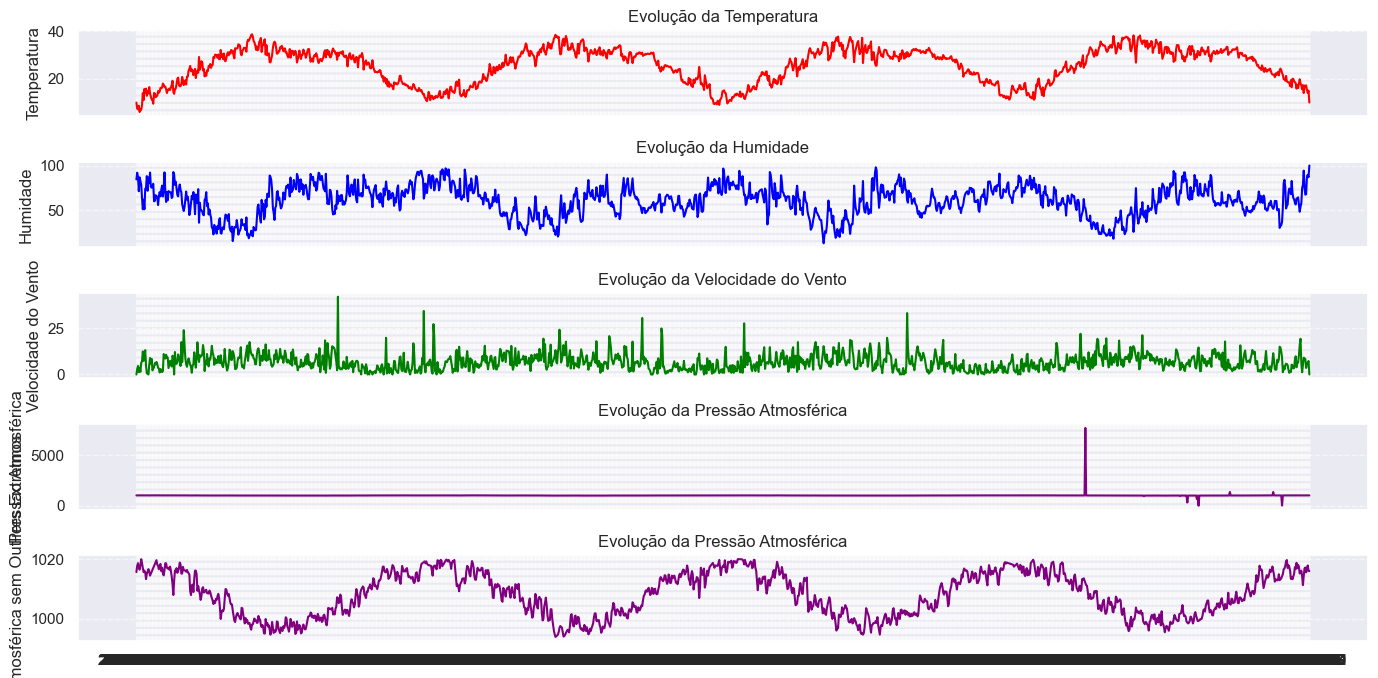

In [37]:
# Criando a figura e os subplots
fig, ax = plt.subplots(5, 1, figsize=(14, 7), sharex=True)  # 4 linhas, 1 coluna

# Gráfico de Temperatura
ax[0].plot(df_climate_train['date'], df_climate_train['meantemp'], linestyle='-', color='red')
ax[0].set_ylabel("Temperatura")
ax[0].set_title("Evolução da Temperatura")
ax[0].grid(True, linestyle="--", alpha=0.6)

# Gráfico de Humidade
ax[1].plot(df_climate_train['date'], df_climate_train['humidity'], linestyle='-', color='blue')
ax[1].set_ylabel("Humidade")
ax[1].set_title("Evolução da Humidade")
ax[1].grid(True, linestyle="--", alpha=0.6)


# Gráfico de Velocidade do Vento
ax[2].plot(df_climate_train['date'], df_climate_train['wind_speed'], linestyle='-', color='green')
ax[2].set_ylabel("Velocidade do Vento")
ax[2].set_title("Evolução da Velocidade do Vento")
ax[2].grid(True, linestyle="--", alpha=0.6)

# Gráfico de Pressão Atmosférica
ax[3].plot(df_climate_train['date'], df_climate_train['meanpressure'], linestyle='-', color='purple')
ax[3].set_ylabel("Pressão Atmosférica")
ax[3].set_title("Evolução da Pressão Atmosférica")
ax[3].grid(True, linestyle="--", alpha=0.6)

# Gráfico de Pressão Atmosférica sem Outliers Extremos
ax[4].plot(df_climate_train.loc[df_climate_train['meanpressure'].between(994, 1020)]['date'], df_climate_train.loc[df_climate_train['meanpressure'].between(994, 1020)]['meanpressure'], linestyle='-', color='purple')
ax[4].set_ylabel("Pressão Atmosférica sem Outliers Extremos")
ax[4].set_title("Evolução da Pressão Atmosférica")
ax[4].grid(True, linestyle="--", alpha=0.6)


# Ajusta o layout para evitar sobreposição
plt.tight_layout()

# Exibir o gráfico
plt.show()


# <font color='green' style='font-size: 30px;'> 2.2) Como se comportam as componentes temporais da série histórica? </font>
<hr style='border: 2px solid green;'>

> 1. Trataremos as componentes através de um Modelo Aditivo

> 2. Modelos aditivos em séries temporais são um tipo de abordagem utilizada para decompor uma série temporal em componentes distintos que podem ser somados para explicar a variação nos dados ao longo do tempo. Esses componentes tipicamente incluem:

- Tendência (Trend): Representa a direção geral dos dados ao longo do tempo (por exemplo, uma tendência crescente ou decrescente).

- Sazonalidade (Seasonality): Captura padrões repetitivos que ocorrem em intervalos regulares (por exemplo, variações sazonais mensais ou anuais).

- Ciclo (Cycle): Refere-se a flutuações de longo prazo que não são devidas a sazonalidade (por exemplo, ciclos econômicos).

- Ruído (Noise): Componentes aleatórios ou erros que não são explicados pelos outros componentes.

## $$ Y_{t} = S_{t} + T{t} + R{t} $$ 

> 3. Pelo gráfico abaixo, nota-se que temos tendência, sazonalidade e o resíduo não aparenta ser um ruído branco (não possuem média zero, variância constante e tem o gráfico de ACF parecido com uma senóide, o que sugere autocorrelação nos resíduos e a presença de uma sazonalidade), portanto, a série aparenta não ser estacionária. Podemos testar isso usando o Teste KPSS e o Dickey-Fuller

No KPSS o teste de hipótese se resume a:

<center>

| Nome do teste | $H_0$ (p-value > 0.05) |  $H_1$ (p-value <= 0.05) |
|---------------|------------------------|--------------------------|
| KPSS | É estacionária | Não é estacionária |

</center>

- O [teste KPSS](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.kpss.html) (Kwiatkowski-Phillips-Schmidt-Shin) compara a série temporal com um modelo estacionário que tem características semelhantes à série. Ele avalia a diferença entre a série real e o modelo estacionário para determinar se a série é estacionária ou não.

- H0: É estacionário --> Não rejeitada caso p-value > 0.05

- H1: Não é estacionário --> Rejeição de H0 caso p-value <= 0.05

No ADF o teste de hipótese se resume a:

<center>

| Nome do teste | $H_0$ (p-value > 0.05) |  $H_1$ (p-value <= 0.05) |
|---------------|------------------------|--------------------------|
| ADF | Não é estacionária | É estacionária |

</center>

- O [teste de Dickey-Fuller Aumentado](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) é um teste estatístico utilizado para verificar a presença de raiz unitária em uma série temporal. Uma série temporal é considerada ter uma raiz unitária se ela não for estacionária, ou seja, se sua média e variância não forem constantes ao longo do tempo. Essa verificação acontece comparando a série temporal original com uma versão diferenciada da mesma. Ele compara a série temporal original com uma versão diferenciada da série. A diferenciação envolve subtrair cada valor da série pelo valor anterior, o que pode ajudar a remover tendências ou padrões de longo prazo na série. 

- H0: Não é estacionário --> Não rejeitada caso p-value > 0.05

- H1: É estacionário --> Rejeição de H0 caso p-value <= 0.05

> 4. Após a realização dos testes, ambos afirmam que a série não é estacionária

In [38]:
df_climate_train_decompose = df_climate_train.set_index('date')

- Temperatura

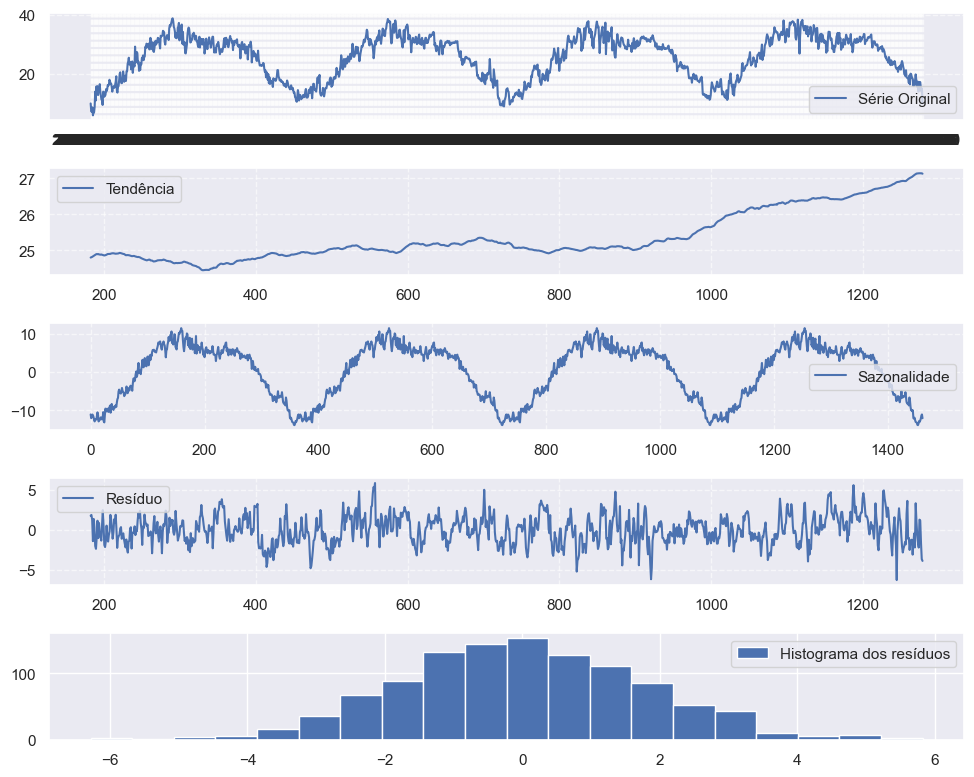

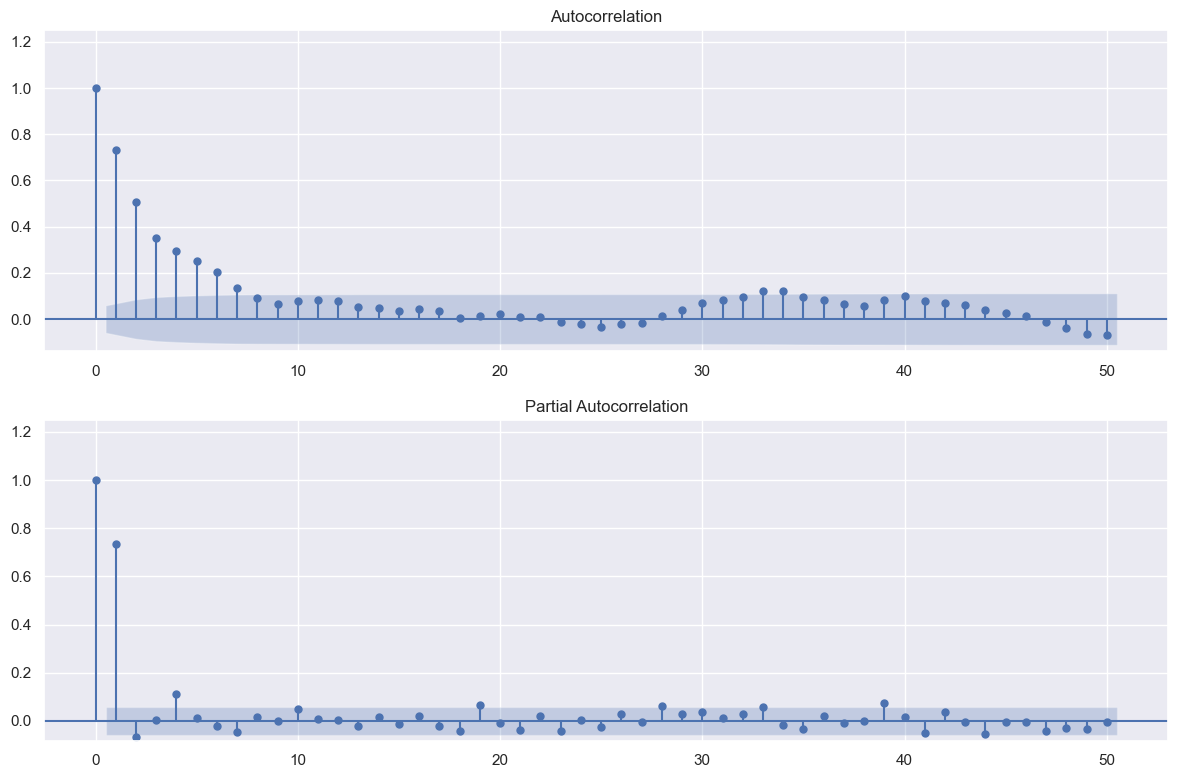

Adfuller
p-value: 0.277
Não estacionária com nível de confiança de 95%


KPSS
p-value: 0.100
Estacionária com nível de confiança de 95%




In [43]:
# Realizar a decomposição da série temporal
result = seasonal_decompose(df_climate_train['meantemp'], model='additive', period=365)

# o primeiro número (5) representa o número total de linhas, e o segundo número (5) representa o índice do subplot dentro da grade. 

# Plotar os componentes decompostos
plt.figure(figsize=(10, 8))

plt.subplot(511)
plt.plot(df_climate_train['date'], df_climate_train['meantemp'], label='Série Original')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(512)
plt.plot(result.trend, label='Tendência')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(513)
plt.plot(result.seasonal,label='Sazonalidade')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(514)
plt.plot(result.resid, label='Resíduo')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(515)
plt.hist(result.resid, bins=20, label="Histograma dos resíduos")
plt.legend()

plt.tight_layout()
plt.show()

plota_acf_pacf(result.resid.dropna())

analisa_estacionaridade(df_climate_train['meantemp'])


# <font color='red' style='font-size: 40px;'> 3) Feature Engineering </font>
<hr style='border: 2px solid red;'>

# <font color='red' style='font-size: 40px;'> 4) Modelagem </font>
<hr style='border: 2px solid red;'>